# Coastal Kelvin Wave Test Case

simulating a coastal kelvin wave

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS/MPAS_Ocean/"

In [8]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [9]:
mpasOcean = MPAS_Ocean(
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh",
                "culled_mesh.nc", "mesh.nc", periodicity="NonPeriodic_x")
ocn_init_routines_compute_max_level!(mpasOcean)

In [12]:
meanCoriolisParameterf = sum(mpasOcean.fCell) / mpasOcean.nCells

0.0010000000000000007

In [13]:
meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)

1000.0

In [14]:
c = sqrt(mpasOcean.gravity*meanFluidThicknessH)

98.99494936611666

In [15]:
rossbyRadiusR = c/meanCoriolisParameterf

98994.94936611659

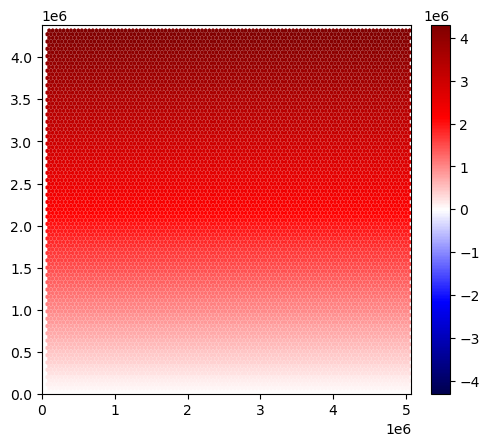

In [16]:
fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.yCell)
display(fig)

## the lateral profile of the kelvin wave, can be any function

In [17]:
function lateralProfileGaussian(y)
    mu = mpasOcean.lY/2#20.0e5
    sigma = 3.0e3
    return 1e-3*exp(- (y .% mpasOcean.lY -mu)^2 / sigma^2) #* cos(y*5.0e-6)
end

lateralProfileGaussian (generic function with 1 method)

In [18]:
function lateralProfilePeriodic(y)
    return cos(y/mpasOcean.lY * 4 * pi)
end

lateralProfilePeriodic (generic function with 1 method)

In [19]:
lateralProfile = lateralProfilePeriodic

lateralProfilePeriodic (generic function with 1 method)

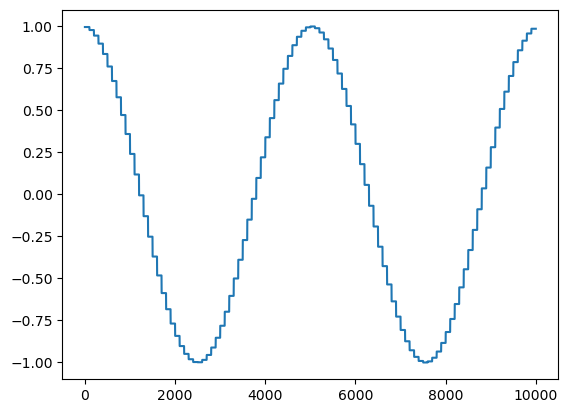

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbca2976880>

In [20]:
plot(lateralProfile.(mpasOcean.yCell))

## set the velocity and ssh to be a kelvin wave

In [21]:
function kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t=0)
    v = sqrt(mpasOcean.gravity*meanFluidThicknessH) * lateralProfile(mpasOcean.yEdge[iEdge] .+ c*t) * exp(-mpasOcean.xEdge[iEdge]/rossbyRadiusR)
    return v*sin(mpasOcean.angleEdge[iEdge])
end

kelvinWaveExactNormalVelocity (generic function with 2 methods)

In [22]:
function kelvinWaveExactSSH(mpasOcean, iCell, t=0)
    return - meanFluidThicknessH * lateralProfile(mpasOcean.yCell[iCell] .+ c*t) * exp(-mpasOcean.xCell[iCell]/rossbyRadiusR)
end

kelvinWaveExactSSH (generic function with 2 methods)

In [23]:
function kelvinWaveExactSolution!(mpasOcean, t=0)
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = kelvinWaveExactSSH(mpasOcean, iCell)
    end
    
    for iEdge in 1:mpasOcean.nEdges
        mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge)
    end
end

kelvinWaveExactSolution! (generic function with 2 methods)

In [33]:
function boundaryCondition!(mpasOcean, t)
    for iEdge in 1:mpasOcean.nEdges
        if mpasOcean.boundaryEdge[iEdge] == 1.0
            mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
        end
    end
    
end

boundaryCondition! (generic function with 1 method)

In [48]:
kelvinWaveExactSolution!(mpasOcean)

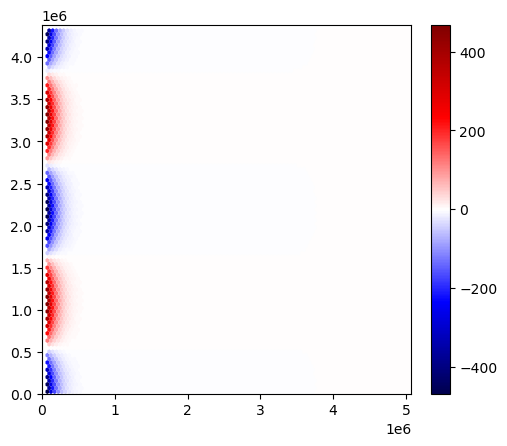

In [49]:
fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

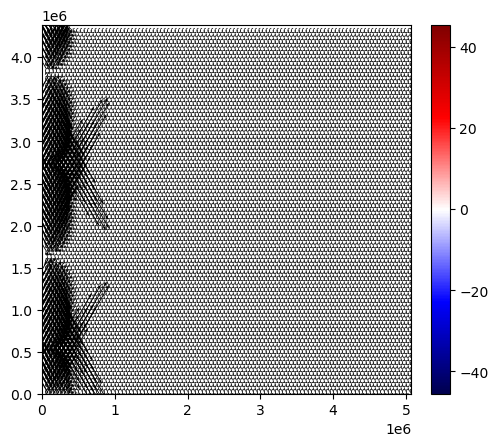

In [50]:
fig, ax, _, = vectorPlotMesh(mpasOcean, mpasOcean.normalVelocityCurrent)
display(fig)

# Simulate wave

In [51]:
nFrames = 20

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))

saveInterval = 10

t = 0

for i in 1:nFrames
    for j in 1:saveInterval
        
        calculate_normal_velocity_tendency!(mpasOcean)
    
        update_normal_velocity_by_tendency!(mpasOcean)

        
        boundaryCondition!(mpasOcean, t)

        
        calculate_ssh_tendency!(mpasOcean)

        update_ssh_by_tendency!(mpasOcean)

        t += mpasOcean.dt
    end
    sshOverTime[i,:] .= mpasOcean.sshCurrent[:]
end

## animate simulation

In [52]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fbc98d2f0d0>

In [53]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# show exact solution

In [57]:
sshOverTimeExact = zeros(Float64, (nFrames, mpasOcean.nCells))

t = 0

for i in 1:nFrames
    t += saveInterval*mpasOcean.dt
    kelvinWaveExactSolution!(mpasOcean, t)
    sshOverTimeExact[i,:] .= mpasOcean.sshCurrent[:]
end

## animate simulation

In [58]:
cMax = maximum(abs.(sshOverTimeExact))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fbca57b6730>

In [59]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# difference between exact and numerical solution

In [45]:
cMax = maximum(abs.(sshOverTimeExact))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:] - sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

LoadError: UndefVarError: sshOverTimeExact not defined

In [207]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [43]:
a = 1.2512333333333342546346347347333333333333333333333385092385098230572395869345687209485720394857

a

1.2512333333333343

In [44]:
convert(Float32, a)

1.2512333f0

In [60]:
b = convert(Float32, a)

1.2512333f0

In [61]:
a*a, b*b

(1.5655848544444468, 1.5655849f0)

In [62]:
a*b

1.5655848619222654